Original Training examples: 60000
Original Test examples: 10000


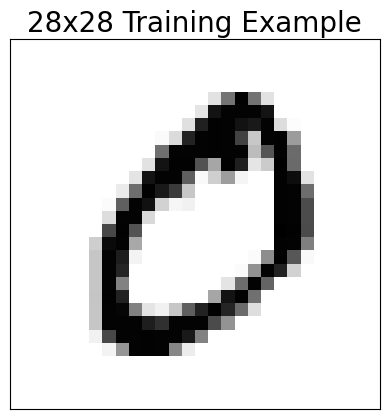

Number of filtered training examples: 12665
Number of filtered test examples: 2115
1/1 [==============================] - 2s 2s/step
Model: "QNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 10)]              0         
                                                                 
 quantumLayer (KerasLayer)   (None, 1)                 57        
                                                                 
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/60
 41/396 [==>...........................] - ETA: 35:19 - loss: 0.9745 - accuracy: 0.5053

KeyboardInterrupt: 

In [1]:
import numpy as np
import pandas as pd
import pennylane as qml
import tensorflow as tf
from matplotlib import pyplot as plt
import pennylane.templates.embeddings as qml_embeddings
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""


tf.keras.backend.set_floatx('float64')


class Preprocessing():

    def __init__(self, dataset, samples_per_class=100):
        (x_train, y_train), (x_test, y_test) = dataset

        x_train, x_test = x_train[..., np.newaxis] / 255.0, x_test[..., np.newaxis] / 255.0

        print('Original Training examples: {}'.format(len(x_train)))
        print('Original Test examples: {}'.format(len(x_test)))

        self.x_train, self.y_train = self.filter_classes(x_train, y_train)
        self.x_test, self.y_test = self.filter_classes(x_test, y_test)
        
        self.plot(self.x_train[0, :, :, 0], '28x28 Training Example')
        
        # Limit the number of samples per class
        #self.x_train, self.y_train = self.limit_samples(self.x_train, self.y_train, samples_per_class)
        #self.x_test, self.y_test = self.limit_samples(self.x_test, self.y_test, samples_per_class)
        
        self.x_train = self.x_train.reshape(self.x_train.shape[0], -1)
        self.x_test = self.x_test.reshape(self.x_test.shape[0], -1)
        
        gamma = 1.0  # Adjust the gamma parameter as needed
        self.kernel_matrix_train = self.rbf_kernel_matrix(self.x_train, self.x_train, gamma)
        self.kernel_matrix_test = self.rbf_kernel_matrix(self.x_test, self.x_train, gamma)
        
        self.kernel_matrix_train = self.reduce_dimensions(self.kernel_matrix_train, 10)
        self.kernel_matrix_test = self.reduce_dimensions(self.kernel_matrix_test, 10)


        print('Number of filtered training examples: {}'.format(len(self.x_train)))
        print('Number of filtered test examples: {}'.format(len(self.x_test)))

  
    def filter_classes(self, x, y):
        keep = (y == 3) | (y == 6)
        x, y = x[keep], y[keep]
        y = y == 3
        return x, y
    
    def plot(self, image, title, vmin = None, vmax = None):
        plt.imshow(image, cmap = 'Greys')
        ax = plt.gca()
        ax.set_xticks([])
        ax.set_yticks([])
        plt.title(title, fontsize = 20)
        plt.show()

    def shrink(self, matrix):
        new_data = tf.image.resize(matrix, (9, 9)).numpy()
        
        return new_data
    
    def limit_samples(self, x_data, y_data, samples_per_class):
        unique_classes = np.unique(y_data)
        x_data_limited = np.empty((0, x_data.shape[1] * x_data.shape[2]))
        y_data_limited = np.empty(0, dtype=y_data.dtype)

        for cls in unique_classes:
            indices = np.where(y_data == cls)
            x_cls = x_data[indices][:samples_per_class]
            y_cls = y_data[indices][:samples_per_class]
            
            x_cls = x_cls.reshape(x_cls.shape[0], -1)

            x_data_limited = np.vstack((x_data_limited, x_cls))
            y_data_limited = np.hstack((y_data_limited, y_cls))

        return x_data_limited, y_data_limited
    
    def reduce_dimensions(self, kernel_matrix, n_dimensions):
        pca = PCA(n_components=n_dimensions)
        reduced_kernel_matrix = pca.fit_transform(kernel_matrix)

        return reduced_kernel_matrix

    def rbf_kernel_matrix(self, x1, x2, gamma):
        pairwise_dists = cdist(x1, x2, 'euclidean')
        K = np.exp(-gamma * pairwise_dists ** 2)
        return K


class QuantumNeuralNetwork():
    def __init__(self, kernel_matrix_train, y_train, kernel_matrix_test, y_test, epochs):
        self.epochs = epochs
        model_1l = self.generate_model(kernel_matrix_train, kernel_matrix_test, layers = 1)
        model_1l.compile(
            loss = tf.keras.losses.Hinge(),
            optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
            metrics = [self.accuracy])
        history_1l, results_1l, model_1l = self.train_model(model_1l, kernel_matrix_train, y_train, kernel_matrix_test, y_test)
        model_1l.save('model_1l.h5')
        history_1l_df = pd.DataFrame(history_1l.history)
        with open('history_1l.csv', mode = 'w') as f:
            history_1l_df.to_csv(f)
        print('\nModel 1 complete!\n')

    def generate_model(self, kernel_matrix_train, kernel_matrix_test, layers):
        n_qubits = 10
        n_layers = layers
        dev = qml.device('default.qubit', wires = n_qubits)

        @qml.qnode(dev, diff_method = 'adjoint')
        def qnode(inputs, weights):
            qml_embeddings.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')

            for ii in range(n_qubits):
                qml.RY(np.pi * inputs[ii], wires = ii)


            for jj in range(n_layers):
                for ii in range(n_qubits - 1):
                    qml.RZ(weights[jj, 2 * ii, 0], wires = 0)
                    qml.RY(weights[jj, 2 * ii, 1], wires = 0)
                    qml.RZ(weights[jj, 2 * ii, 2], wires = 0)

                    qml.RZ(weights[jj, 2 * ii + 1, 0], wires = ii + 1)
                    qml.RY(weights[jj, 2 * ii + 1, 1], wires = ii + 1)
                    qml.RZ(weights[jj, 2 * ii + 1, 2], wires = ii + 1)

                    qml.CNOT(wires = [ii + 1, 0])
                    
                qml.RZ(weights[jj, 2 * (n_qubits - 1), 0], wires = 0)
                qml.RY(weights[jj, 2 * (n_qubits - 1), 1], wires = 0)
                qml.RZ(weights[jj, 2 * (n_qubits - 1), 2], wires = 0)

            return qml.expval(qml.PauliZ(0))

        weight_shapes = {'weights': (n_layers, 2 * (n_qubits - 1) + 1, 3)}
        qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim = 1, name = 'quantumLayer')
        inputs = tf.keras.Input(shape=(n_qubits,), name='inputs')
        outputs = qlayer(inputs)
        model = tf.keras.Model(inputs = inputs, outputs = outputs, name = 'QNN')
        x = np.reshape(kernel_matrix_test[0,:], (1, -1))
        model.predict(x)
        print(model.summary())
        
        return model

    def train_model(self, model, kernel_matrix_train, y_train, kernel_matrix_test, y_test):
        EPOCHS = self.epochs
        BATCH_SIZE = 32
        NUM_EXAMPLES = kernel_matrix_train.shape[0]

        x_train_sub = kernel_matrix_train[:NUM_EXAMPLES, :]

        y_train_hinge = 2.0 * y_train - 1.0
        y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

        x_test_sub = kernel_matrix_test[:, :]
        y_test_sub = y_test[:]

        qnn_history = model.fit(
            x_train_sub,
            y_train_hinge_sub,
            batch_size = BATCH_SIZE,
            epochs = EPOCHS,
            verbose = 1,
            validation_data = (x_test_sub, y_test_sub))
        
        qnn_results = model.evaluate(x_test_sub, y_test_sub)
        
        return qnn_history, qnn_results, model

    def accuracy(self, y_true, y_pred):
        y_true = tf.squeeze(y_true) > 0.0
        y_pred = tf.squeeze(y_pred) > 0.0
        result = tf.cast(y_true == y_pred, tf.float32)

        return tf.reduce_mean(result)

class Plot():
    def __init__(self,
                 history_1l,
                 epochs):
        for col in history_1l.columns:
            plt.plot(np.arange(1, epochs + 1), history_1l[col], label = '1 layer QNN')
            plt.xlabel('Epochs')
            plt.ylabel(col)
            plt.legend()
            plt.xticks(np.arange(0, epochs + 1, 2))
            plt.yticks(np.arange(0, 1.1, 0.1))
            plt.savefig('{}.png'.format(col), bbox_inches = 'tight', pad_inches = 0)
            plt.show()
    
def main():
    epochs = 60
    dataset = Preprocessing(tf.keras.datasets.mnist.load_data(), samples_per_class=10000)
    kernel_matrix_train, y_train, kernel_matrix_test, y_test = dataset.kernel_matrix_train, dataset.y_train, dataset.kernel_matrix_test, dataset.y_test
    QuantumNeuralNetwork(kernel_matrix_train, y_train, kernel_matrix_test, y_test, epochs)

    history_1l = pd.read_csv('history_1l.csv')
    Plot(history_1l,
         epochs)
    
main()